In [17]:
import json
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from random import shuffle, choices
import matplotlib.pyplot as plt

from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score
import warnings
warnings.filterwarnings('ignore')

In [82]:
DH.target_col

['SD', 'QE', 'SV', 'PR', 'HD']

In [19]:
from GRU_pipeline import DataHolder, paths, dicDataset, GRUModel, pad_collate, HierarchicalDataset

DH = DataHolder(**paths)
#HD = HierarchicalDataset(DH)
#dl = HD.dataloader()

In [29]:
output = DH.make_train_test_datasets(test_size = .15, val_size = .17)
class_weights = output['class_weights']
openface_1  = output['datasets']['openface_1']
openface_2  = output['datasets']['openface_2']
opensmile_1 = output['datasets']['opensmile_1']
opensmile_2 = output['datasets']['opensmile_2']

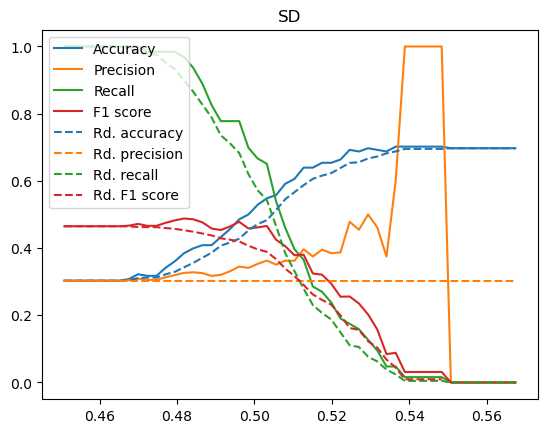

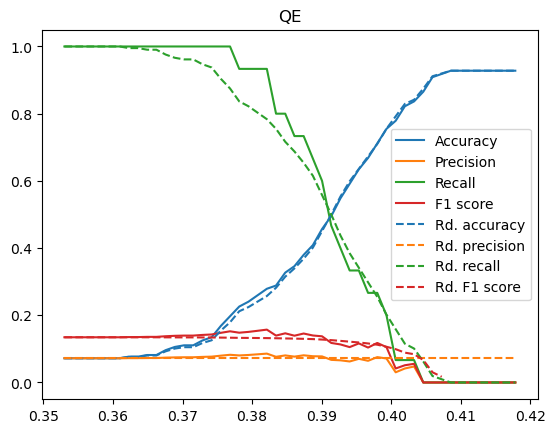

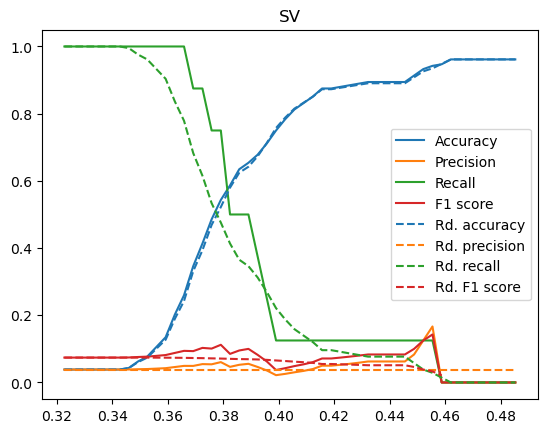

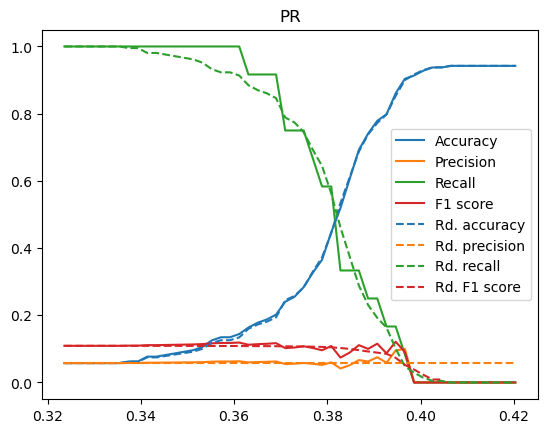

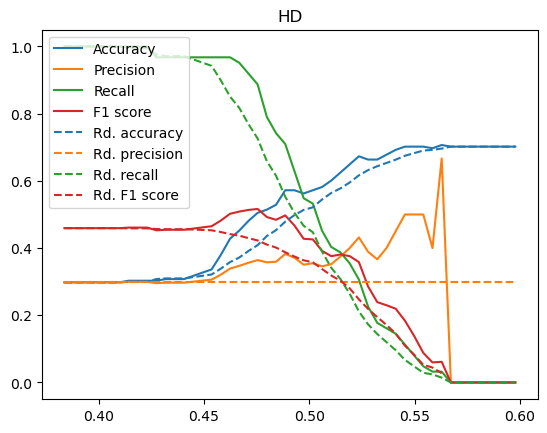

In [124]:
args={
    'model': GRUModel(input_dim=17),
    'features_1':openface_1,
    'features_2':openface_2,
    'criterion':nn.KLDivLoss()
}
#pipe = Pipeline(**args)
#pipe.train(epoch=100)
#pipe.plot_losses()
pipe.eval_model()

In [123]:
class Pipeline():
    def __init__(self, model, features_1, features_2, criterion, cats=['SD', 'QE', 'SV', 'PR', 'HD']):
        self.datasets = {1 : features_1, 2 : features_2}
        self.criterion = criterion
        self.model = model
        self.hist_train_loss = None
        self.hist_test_loss = None
        self.hist_val_loss = None
        self.cats = cats

    def eval_on_batch(self, batch):
        self.model.eval()
        with torch.no_grad():
            pred = self.model(batch['features'])
        return ( self.criterion(batch['targets'], pred) / pred.shape[0] ).detach().numpy()
    
    def train(self, batch_size=50, epoch=50, lr=1e-4, early_stop=None):

        if not self.hist_train_loss :
            self.hist_train_loss = []
            self.hist_eval_loss = []
            self.hist_test_loss = []
        
        test1, eval1 = self.datasets[1].get_test(), self.datasets[1].get_valid()
        test2, eval2 = self.datasets[2].get_test(), self.datasets[2].get_valid()

        dataloader1 = DataLoader(self.datasets[1], batch_size = batch_size, shuffle = True, collate_fn = pad_collate)
        dataloader2 = DataLoader(self.datasets[2], batch_size = batch_size, shuffle = True, collate_fn = pad_collate)

        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)

        self.model.train()
        for e in range(epoch):
            epoch_loss = 0.0

            for batch1,batch2 in zip(dataloader1,dataloader2):

                pred1 = self.model(batch1['features'])
                loss1 = self.criterion(batch1['targets'], pred1)

                epoch_loss += loss1

                optimizer.zero_grad()
                loss1.backward()
                optimizer.step()

                pred2 = self.model(batch2['features'])
                loss2 = self.criterion(batch2['targets'], pred2)

                epoch_loss += loss2

                optimizer.zero_grad()
                loss2.backward()
                optimizer.step()
            
            if (e+1)%(epoch//5)==0:
                print(f"loss epoch {e}: {epoch_loss:2f}")
        
            self.hist_train_loss.append((loss1+loss2).detach().numpy()/len(dataset))

            test_loss = self.eval_on_batch(test1) + self.eval_on_batch(test2)
            self.hist_test_loss.append(test_loss)
            eval_loss = self.eval_on_batch(eval1) + self.eval_on_batch(eval2)
            self.hist_eval_loss.append(eval_loss)
        return None

    def plot_losses(self):
        fig, ax = plt.subplots(1,3, figsize=(18,4))
        ax[0].plot(self.hist_train_loss)
        ax[0].set_title('Train')
        ax[1].plot(self.hist_eval_loss)
        ax[1].set_title('Eval')
        ax[2].plot(self.hist_test_loss)
        ax[2].set_title('Test')
        plt.show()
        return None
    
    def eval_model(self):

        test1 = self.datasets[1].get_test()
        test2 = self.datasets[2].get_test()

        pred1 = self.model(test1['features']).detach().numpy()
        pred2 = self.model(test2['features']).detach().numpy()
        pred = np.concatenate((pred1,pred2), axis=0)

        true1 = test1['targets'].detach().numpy()
        true2 = test2['targets'].detach().numpy()
        true = np.concatenate((true1,true2), axis=0)

        #fig, ax = plt.subplots(len(self.cats),2, figsize=(18,7))

        for i, cat in enumerate(self.cats):
            rd = simulate_randomness(true[:,i],pred[:,i])
            res = explore_tresh(true[:,i],pred[:,i])

            ax = res.plot(color =list(mcolors.TABLEAU_COLORS.values()) )#ax=ax[i][0])
            rd.plot( ax=ax, linestyle='dashed',color =list(mcolors.TABLEAU_COLORS.values()))#ax=ax[i][0])
            plt.title(self.cats[i])
            plt.show()

def simulate_randomness(true, pred):
    w = pred.max() - pred.min()
    tresh = np.linspace(pred.min()-.2*w,pred.max()+.2*w,50)
    p=true.sum()/true.shape[0]
    func = lambda t : np.where(pred > t,1,0).mean()
    out = [(
        func(t)*(2*p-1) + 1 - p,
        p,
        func(t),
        (2*p*func(t)) / (p + func(t)) if func(t) > 0 else np.nan
    ) for t in tresh]
    out = pd.DataFrame(out, columns=['Rd. accuracy', 'Rd. precision', 'Rd. recall', 'Rd. F1 score'], index=tresh)
    return out

def explore_tresh(true, pred):
    w = pred.max() - pred.min()
    prop=true.sum()/true.shape[0]
    tresh = np.linspace(pred.min()-.2*w,pred.max()+.2*w,50)
    out = [(
        accuracy_score(true, np.where(pred>t,1,0)),
        precision_score(true, np.where(pred>t,1,0)),
        recall_score(true, np.where(pred>t,1,0)),
        f1_score(true, np.where(pred>t,1,0))
    ) for t in tresh]
    out = pd.DataFrame(out, columns=['Accuracy', 'Precision', 'Recall', 'F1 score'], index=tresh)
    return out



In [ ]:
plt.Figure()

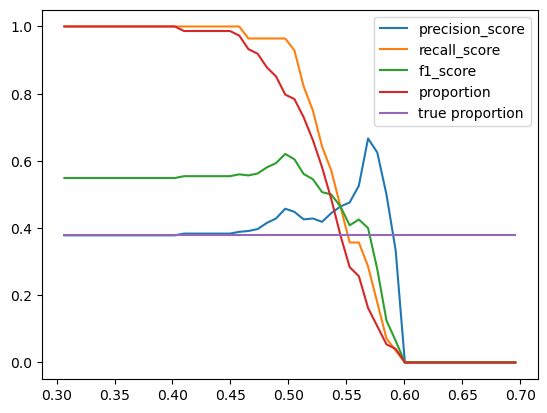

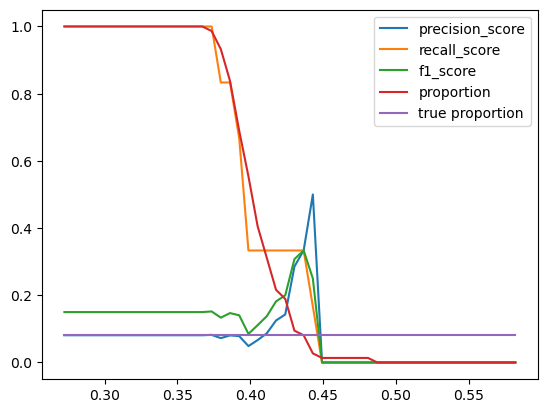

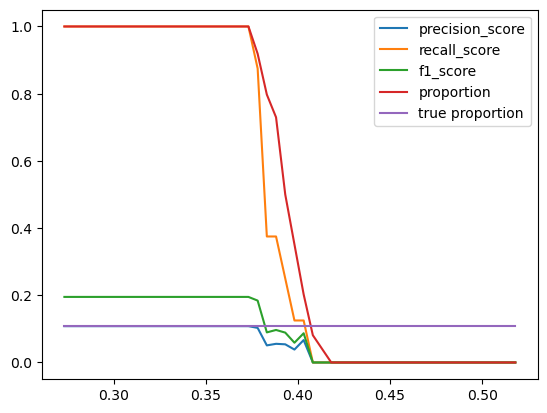

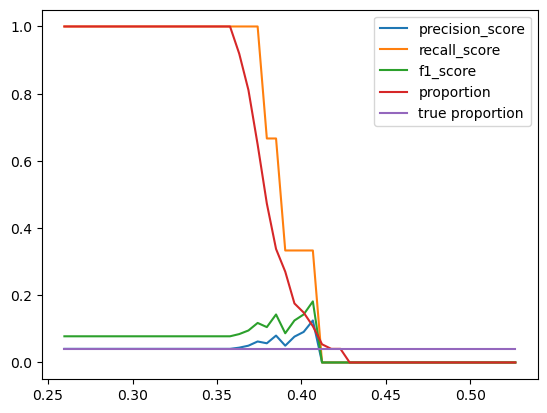

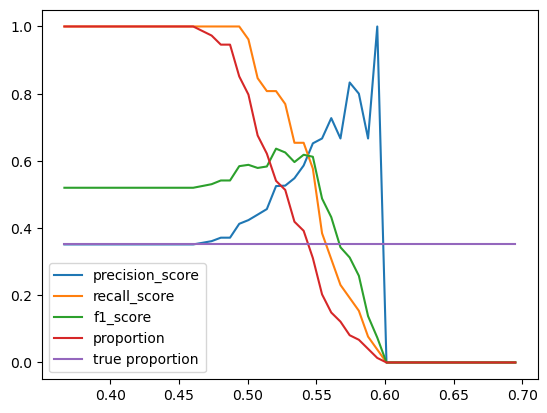

In [ ]:
y_test = dataset.get_test()
pred_n = model(y_test['features']).detach().numpy()
y_true = y_test['targets'].detach().numpy()

def explore_tresh(true, pred):
    w = pred.max() - pred.min()
    tresh = np.linspace(pred.min()-.2*w,pred.max()+.2*w,50)
    out = [(
        precision_score(true, np.where(pred>t,1,0)),
        recall_score(true, np.where(pred>t,1,0)),
        f1_score(true, np.where(pred>t,1,0)),
        np.where(pred>t,1,0).sum() / pred.shape[0],
        true.sum()/true.shape[0]
    ) for t in tresh]
    out = pd.DataFrame(out, columns=['precision_score', 'recall_score', 'f1_score', 'proportion', 'true proportion'], index=tresh)
    return out

for i in range(5):
    explore_tresh(y_true[:,i], pred_n[:,i]).plot()

In [111]:
list(mcolors.TABLEAU_COLORS.values())

['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd',
 '#8c564b',
 '#e377c2',
 '#7f7f7f',
 '#bcbd22',
 '#17becf']

<AxesSubplot: >

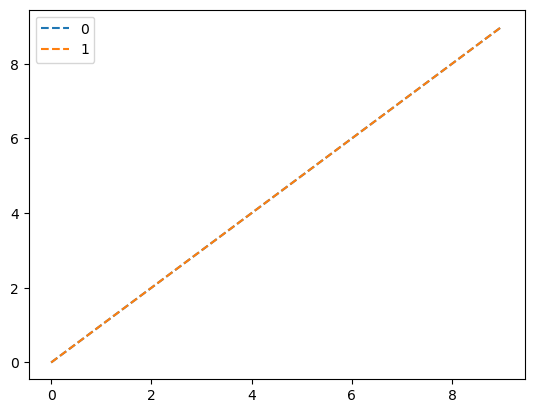

In [113]:
pd.DataFrame(list(zip(range(10), range(10)))).plot(linestyle='dashed',color =list(mcolors.TABLEAU_COLORS.values()))

In [105]:
help(pd.DataFrame.plot)
import matplotlib.colors as mcolors

Help on class PlotAccessor in module pandas.plotting._core:

class PlotAccessor(pandas.core.base.PandasObject)
 |  PlotAccessor(data) -> 'None'
 |  
 |  Make plots of Series or DataFrame.
 |  
 |  Uses the backend specified by the
 |  option ``plotting.backend``. By default, matplotlib is used.
 |  
 |  Parameters
 |  ----------
 |  data : Series or DataFrame
 |      The object for which the method is called.
 |  x : label or position, default None
 |      Only used if data is a DataFrame.
 |  y : label, position or list of label, positions, default None
 |      Allows plotting of one column versus another. Only used if data is a
 |      DataFrame.
 |  kind : str
 |      The kind of plot to produce:
 |  
 |      - 'line' : line plot (default)
 |      - 'bar' : vertical bar plot
 |      - 'barh' : horizontal bar plot
 |      - 'hist' : histogram
 |      - 'box' : boxplot
 |      - 'kde' : Kernel Density Estimation plot
 |      - 'density' : same as 'kde'
 |      - 'area' : area plot
 | 